Question 1

In [37]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import recall_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier

s3 = boto3.resource('s3')
bucket_name = 'grant-gonnerman-data-445'
bucket = s3.Bucket(bucket_name)

file_key = 'weather.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

# reading data file
weather = pd.read_csv(file_content_stream)
weather.head()

,rowID,hpwren_timestamp,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,rain_accumulation,rain_duration,relative_humidity
0,0,2011-09-10 00:00:49,912.3,64.76,97.0,1.2,106.0,1.6,85.0,1.0,NaN,NaN,60.5
1,1,2011-09-10 00:01:49,912.3,63.86,161.0,0.8,215.0,1.5,43.0,0.2,0.0,0.0,39.9
2,2,2011-09-10 00:02:49,912.3,64.22,77.0,0.7,143.0,1.2,324.0,0.3,0.0,0.0,43.0
3,3,2011-09-10 00:03:49,912.3,64.40,89.0,1.2,112.0,1.6,12.0,0.7,0.0,0.0,49.5
4,4,2011-09-10 00:04:49,912.3,64.40,185.0,0.4,260.0,1.0,100.0,0.1,0.0,0.0,58.8


In [2]:
# dropping data after October 31, 2011 and removing missing values 
weather = weather[weather['hpwren_timestamp'] < '2011-10-31']
weather = weather.dropna()
weather.head()

,rowID,hpwren_timestamp,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,rain_accumulation,rain_duration,relative_humidity
1,1,2011-09-10 00:01:49,912.3,63.86,161.0,0.8,215.0,1.5,43.0,0.2,0.0,0.0,39.9
2,2,2011-09-10 00:02:49,912.3,64.22,77.0,0.7,143.0,1.2,324.0,0.3,0.0,0.0,43.0
3,3,2011-09-10 00:03:49,912.3,64.40,89.0,1.2,112.0,1.6,12.0,0.7,0.0,0.0,49.5
4,4,2011-09-10 00:04:49,912.3,64.40,185.0,0.4,260.0,1.0,100.0,0.1,0.0,0.0,58.8
5,5,2011-09-10 00:05:49,912.3,63.50,76.0,2.5,92.0,3.0,61.0,2.0,0.0,0.0,62.6


In [3]:
# selecting recomended variables
weather = weather[['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 'max_wind_speed', 'relative_humidity']]

# scaling the data
scaler = MinMaxScaler()
weather[['air_pressure_01', 'air_temp_01', 'avg_wind_direction_01', 'avg_wind_speed_01', 'max_wind_direction_01', 'max_wind_speed_01', 'relative_humidity_01']] = scaler.fit_transform(weather)

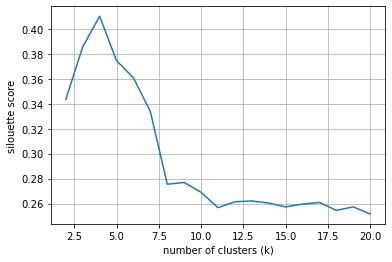

In [4]:
## list to store silhouette score
silouette = list()

for i in range(2,21):
    #clustering the data
    kmeans_md = KMeans(n_clusters = i, n_init = 20).fit(weather[['air_pressure_01', 'air_temp_01', 'avg_wind_direction_01', 'avg_wind_speed_01', 'max_wind_direction_01', 'max_wind_speed_01', 'relative_humidity_01']])
    kmeans_labels = kmeans_md.labels_
    
    #computing score
    score = silhouette_score(weather[['air_pressure_01', 'air_temp_01', 'avg_wind_direction_01', 'avg_wind_speed_01', 'max_wind_direction_01', 'max_wind_speed_01', 'relative_humidity_01']], kmeans_labels)
    silouette.append(score)
    
plt.plot(range(2,21), silouette)
plt.xlabel('number of clusters (k)')
plt.ylabel('silouette score')
plt.grid()
plt.show()

In [6]:
#clustering data with best estimated cluster (4)
kmeans_md = KMeans(n_clusters = 4, n_init = 20).fit(weather[['air_pressure_01', 'air_temp_01', 'avg_wind_direction_01', 'avg_wind_speed_01', 'max_wind_direction_01', 'max_wind_speed_01', 'relative_humidity_01']])

#append data
weather['cluster'] = kmeans_md.labels_
weather.head()

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity,air_pressure_01,air_temp_01,avg_wind_direction_01,avg_wind_speed_01,max_wind_direction_01,max_wind_speed_01,relative_humidity_01,cluster
1,912.3,63.86,161.0,0.8,215.0,1.5,39.9,0.16,0.403922,0.448468,0.034188,0.598886,0.054264,0.400000,2
2,912.3,64.22,77.0,0.7,143.0,1.2,43.0,0.16,0.411765,0.214485,0.029915,0.398329,0.042636,0.435429,0
3,912.3,64.40,89.0,1.2,112.0,1.6,49.5,0.16,0.415686,0.247911,0.051282,0.311978,0.058140,0.509714,0
4,912.3,64.40,185.0,0.4,260.0,1.0,58.8,0.16,0.415686,0.515320,0.017094,0.724234,0.034884,0.616000,1
5,912.3,63.50,76.0,2.5,92.0,3.0,62.6,0.16,0.396078,0.211699,0.106838,0.256267,0.112403,0.659429,0


In [7]:
weather_0 = weather[weather['cluster'] == 0]
weather_0.describe()  

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity,air_pressure_01,air_temp_01,avg_wind_direction_01,avg_wind_speed_01,max_wind_direction_01,max_wind_speed_01,relative_humidity_01,cluster
count,27909.000000,27909.000000,27909.000000,27909.000000,27909.000000,27909.000000,27909.000000,27909.000000,27909.000000,27909.000000,27909.000000,27909.000000,27909.000000,27909.000000,27909.0
mean,916.975714,70.895679,43.049948,2.176470,58.790963,2.638876,30.846483,0.627571,0.557204,0.119916,0.093012,0.163763,0.098406,0.296531,0.0
std,1.540898,6.899162,27.933738,1.331265,30.320238,1.555150,13.165601,0.154090,0.150309,0.077810,0.056892,0.084457,0.060277,0.150464,0.0
min,911.300000,46.040000,0.000000,0.100000,0.000000,0.100000,4.900000,0.060000,0.015686,0.000000,0.004274,0.000000,0.000000,0.000000,0.0
25%,915.700000,65.840000,21.000000,1.200000,37.000000,1.500000,22.100000,0.500000,0.447059,0.058496,0.051282,0.103064,0.054264,0.196571,0.0
50%,917.200000,71.240000,40.000000,1.900000,54.000000,2.300000,28.400000,0.650000,0.564706,0.111421,0.081197,0.150418,0.085271,0.268571,0.0
75%,918.200000,75.560000,58.000000,2.800000,72.000000,3.400000,36.300000,0.750000,0.658824,0.161560,0.119658,0.200557,0.127907,0.358857,0.0
max,920.700000,90.680000,132.000000,8.900000,248.000000,11.000000,79.700000,1.000000,0.988235,0.367688,0.380342,0.690808,0.422481,0.854857,0.0


In [8]:
weather_1 = weather[weather['cluster'] == 1]
weather_1.describe()

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity,air_pressure_01,air_temp_01,avg_wind_direction_01,avg_wind_speed_01,max_wind_direction_01,max_wind_speed_01,relative_humidity_01,cluster
count,16277.000000,16277.000000,16277.000000,16277.000000,16277.000000,16277.000000,16277.000000,16277.000000,16277.000000,16277.000000,16277.000000,16277.000000,16277.000000,16277.000000,16277.0
mean,915.714831,54.362885,193.004608,2.554936,203.492167,3.158813,82.363077,0.501483,0.197013,0.537617,0.109185,0.566831,0.118559,0.885292,1.0
std,1.770431,5.251055,68.950117,1.904449,70.848664,2.248936,10.911622,0.177043,0.114402,0.192062,0.081387,0.197350,0.087168,0.124704,0.0
min,910.700000,45.320000,0.000000,0.100000,0.000000,0.100000,47.800000,0.000000,0.000000,0.000000,0.004274,0.000000,0.000000,0.490286,1.0
25%,914.700000,50.720000,172.000000,1.100000,184.000000,1.500000,72.200000,0.400000,0.117647,0.479109,0.047009,0.512535,0.054264,0.769143,1.0
50%,915.700000,53.060000,197.000000,2.100000,208.000000,2.600000,89.200000,0.500000,0.168627,0.548747,0.089744,0.579387,0.096899,0.963429,1.0
75%,916.900000,57.920000,226.000000,3.600000,239.000000,4.300000,91.500000,0.620000,0.274510,0.629526,0.153846,0.665738,0.162791,0.989714,1.0
max,920.000000,68.720000,359.000000,23.400000,359.000000,25.900000,92.400000,0.930000,0.509804,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


In [9]:
weather_2 = weather[weather['cluster'] == 2]
weather_2.describe()

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity,air_pressure_01,air_temp_01,avg_wind_direction_01,avg_wind_speed_01,max_wind_direction_01,max_wind_speed_01,relative_humidity_01,cluster
count,25553.000000,25553.000000,25553.000000,25553.000000,25553.000000,25553.000000,25553.000000,25553.000000,25553.000000,25553.000000,25553.000000,25553.000000,25553.000000,25553.000000,25553.0
mean,916.991038,72.766312,211.952334,2.180644,229.774038,2.701718,34.990557,0.629104,0.597959,0.590396,0.093190,0.640039,0.100842,0.343892,2.0
std,1.577699,5.599771,52.643671,1.316925,53.985782,1.479473,13.077563,0.157770,0.121999,0.146640,0.056279,0.150378,0.057344,0.149458,0.0
min,911.100000,52.520000,66.000000,0.000000,140.000000,0.100000,4.900000,0.040000,0.156863,0.183844,0.000000,0.389972,0.000000,0.000000,2.0
25%,915.900000,68.720000,177.000000,1.100000,189.000000,1.500000,25.200000,0.520000,0.509804,0.493036,0.047009,0.526462,0.054264,0.232000,2.0
50%,917.100000,72.320000,200.000000,2.000000,215.000000,2.500000,33.200000,0.640000,0.588235,0.557103,0.085470,0.598886,0.093023,0.323429,2.0
75%,918.100000,77.000000,224.000000,3.000000,247.000000,3.700000,44.400000,0.740000,0.690196,0.623955,0.128205,0.688022,0.139535,0.451429,2.0
max,920.700000,91.220000,357.000000,8.600000,359.000000,10.100000,66.200000,1.000000,1.000000,0.994429,0.367521,1.000000,0.387597,0.700571,2.0


In [10]:
weather_3 = weather[weather['cluster'] == 3]
weather_3.describe()

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity,air_pressure_01,air_temp_01,avg_wind_direction_01,avg_wind_speed_01,max_wind_direction_01,max_wind_speed_01,relative_humidity_01,cluster
count,3290.000000,3290.000000,3290.000000,3290.000000,3290.000000,3290.000000,3290.000000,3290.000000,3290.000000,3290.000000,3290.000000,3290.000000,3290.000000,3290.000000,3290.0
mean,916.802675,70.657653,341.153799,1.515198,21.340426,2.136018,33.960486,0.610267,0.552019,0.950289,0.064752,0.059444,0.078915,0.332120,3.0
std,1.430753,7.499031,20.278782,1.016483,22.641070,1.289731,13.958426,0.143075,0.163378,0.056487,0.043439,0.063067,0.049990,0.159525,0.0
min,911.600000,46.220000,209.000000,0.000000,0.000000,0.100000,8.700000,0.090000,0.019608,0.582173,0.000000,0.000000,0.000000,0.043429,3.0
25%,915.800000,66.200000,335.000000,0.700000,5.000000,1.200000,25.025000,0.510000,0.454902,0.933148,0.029915,0.013928,0.042636,0.230000,3.0
50%,916.900000,71.600000,348.000000,1.300000,14.000000,1.900000,29.900000,0.620000,0.572549,0.969359,0.055556,0.038997,0.069767,0.285714,3.0
75%,917.900000,76.460000,355.000000,2.100000,29.000000,2.800000,39.400000,0.720000,0.678431,0.988858,0.089744,0.080780,0.104651,0.394286,3.0
max,920.700000,90.500000,359.000000,7.000000,154.000000,8.700000,90.100000,1.000000,0.984314,1.000000,0.299145,0.428969,0.333333,0.973714,3.0


In [ ]:
# from the clusters we can see... cluster 1 has a low avg_wind_direction and a low max_wind_direction 
#                                 cluster 2 has a low air_temp but a high relative_humidity
#                                 cluster 3 has a mid range avg_wind_speed and max_wind_direction
#                                 cluster 4 has a high avg_wind_direction but a low max_wind_direction
# the clusters were a bit difficut distinguish could possibly play around with the number of clusters to see if that would adjust anything

Question 2

In [26]:
file_key2 = 'churn-bigml-80.csv'

bucket_object2 = bucket.Object(file_key2)
file_object2 = bucket_object2.get()
file_content_stream2 = file_object2.get('Body')

# reading data file
telecom_train = pd.read_csv(file_content_stream2)
telecom_train.head()

,State,Account_length,Area_code,International_plan,Voice_mail_plan,Number_vmail_messages,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,Total_eve_calls,Total_eve_charge,Total_night_minutes,Total_night_calls,Total_night_charge,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Customer_service_calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [27]:
file_key3 = 'churn-bigml-20.csv'

bucket_object3 = bucket.Object(file_key3)
file_object3 = bucket_object3.get()
file_content_stream3 = file_object3.get('Body')

# reading data file
telecom_test = pd.read_csv(file_content_stream3)
telecom_test.head()

,State,Account_length,Area_code,International_plan,Voice_mail_plan,Number_vmail_messages,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,Total_eve_calls,Total_eve_charge,Total_night_minutes,Total_night_calls,Total_night_charge,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Customer_service_calls,Churn
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True
2,NY,161,415,No,No,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,True
3,SC,111,415,No,No,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2,False
4,HI,49,510,No,No,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.00,1,False


In [28]:
# feature engineering 
telecom_train['Churn_numb'] = np.where(telecom_train['Churn'] == True, 1, 0)
telecom_test['Churn_numb'] = np.where(telecom_test['Churn'] == True, 1, 0)

telecom_train['International_plan'].replace(['Yes', 'No'], [1, 0], inplace = True)
telecom_test['International_plan'].replace(['Yes', 'No'], [1, 0], inplace = True)

telecom_train['Voice_mail_plan'].replace(['Yes', 'No'], [1, 0], inplace = True)
telecom_test['Voice_mail_plan'].replace(['Yes', 'No'], [1, 0], inplace = True)

telecom_train['Total_charge'] = telecom_train[['Total_day_charge','Total_eve_charge', 'Total_night_charge', 'Total_intl_charge']].sum(axis = 1)
telecom_test['Total_charge'] = telecom_test[['Total_day_charge','Total_eve_charge', 'Total_night_charge', 'Total_intl_charge']].sum(axis = 1)

telecom_test.head()

,State,Account_length,Area_code,International_plan,Voice_mail_plan,Number_vmail_messages,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,Total_eve_calls,Total_eve_charge,Total_night_minutes,Total_night_calls,Total_night_charge,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Customer_service_calls,Churn,Churn_numb,Total_charge
0,LA,117,408,0,0,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False,0,73.32
1,IN,65,415,0,0,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True,1,54.20
2,NY,161,415,0,0,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,True,1,92.29
3,SC,111,415,0,0,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2,False,0,41.05
4,HI,49,510,0,0,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.00,1,False,0,49.60


In [29]:
telecom_train = telecom_train[['Account_length', 'International_plan', 'Voice_mail_plan', 'Total_charge','Customer_service_calls', 'Churn_numb']]
telecom_test = telecom_test[['Account_length', 'International_plan', 'Voice_mail_plan', 'Total_charge','Customer_service_calls', 'Churn_numb']]
telecom_test.head()

,Account_length,International_plan,Voice_mail_plan,Total_charge,Customer_service_calls,Churn_numb
0,117,0,0,73.32,1,0
1,65,0,0,54.20,4,1
2,161,0,0,92.29,4,1
3,111,0,0,41.05,2,0
4,49,0,0,49.60,1,0


In [43]:
# defining input and target variables
x = telecom_train[['Account_length', 'International_plan', 'Voice_mail_plan', 'Total_charge','Customer_service_calls']]
y = telecom_train['Churn_numb']

# list to store coefficents 
rf_importances = list()
ada_importances = list()
gb_importances = list()

for i in range(0, 1000):
    # splitting the data into train and test 
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2, stratify = y)

    #transforming the input data
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)

    # building RF model
    rf_md = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(x_train, y_train)
    # extracting importances
    rf_importances.append(rf_md.feature_importances_)

    # Ada Boost model
    ada_md = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 3), n_estimators = 500, learning_rate = .01).fit(x_train, y_train)
    ada_importances.append(ada_md.feature_importances_)

    # gradient boosting
    gb_md = GradientBoostingClassifier(max_depth = 3, n_estimators = 500, learning_rate = .01).fit(x_train, y_train)
    gb_importances.append(gb_md.feature_importances_)
    

In [69]:
rf_results = pd.DataFrame(rf_importances)
rf_results.columns = [x] 

ada_results = pd.DataFrame(ada_importances)
ada_results.columns = [x] 

gb_results = pd.DataFrame(gb_importances)
gb_results.columns = [x] 

avg_importance = pd.DataFrame({'RF Importance': np.mean(rf_results), 'Ada Importance': np.mean(ada_results), 'GB Importance': np.mean(gb_results)})
avg_importance['Total AVG'] = avg_importance.mean(axis = 1)
avg_importance = avg_importance.sort_values(by = 'Total AVG', ascending = False)
avg_importance

,RF Importance,Ada Importance,GB Importance,Total AVG
Total_charge,0.555640,0.342629,0.571997,0.490089
International_plan,0.143754,0.249283,0.118026,0.170355
Customer_service_calls,0.208173,0.072435,0.163247,0.147951
Account_length,0.019546,0.300182,0.015249,0.111659
Voice_mail_plan,0.072888,0.035471,0.131481,0.079946


In [ ]:
# defining input and target variables
x = telecom_train[['Account_length', 'International_plan', 'Total_charge','Customer_service_calls']]
y = telecom_train['Churn_numb']

# splitting the data into train and test 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2, stratify = y)

from itertools import product
def expand_grid(dictionary):
    return pd.DataFrame([row for row in product(*dictionary.values())], columns = dictionary.keys())
rf_dictionary = {'n_tree': [100, 500, 1000, 1500, 2000], 'depth': [3, 5, 7]}
rf_parameters = expand_grid(rf_dictionary)
ada_gb_dictionary = {'n_tree': [100, 500, 1000, 1500, 2000], 'depth': [3, 5, 7], 'learning_rate': [0.1, 0.01, 0.001]}
ada_gb_parameters = expand_grid(ada_gb_dictionary)

rf_recall_results = pd.DataFrame()
rf_accuracy_results = pd.DataFrame()
ada_recall_results = pd.DataFrame()
ada_accuracy_results = pd.DataFrame()
gb_recall_results = pd.DataFrame()
gb_accuracy_results = pd.DataFrame()

for j in range(0,100):
    rf_recall = list()
    rf_accuracy = list()
    ada_recall = list()
    ada_accuracy = list()
    gb_recall = list()
    gb_accuracy = list()

    for i in range(0, len(rf_parameters)):
        # RF model
        rf_md = RandomForestClassifier(n_estimators = rf_parameters['n_tree'][i], max_depth = rf_parameters['depth'][i]).fit(x_train, y_train)
        # predicting on test
        rf_pred = rf_md.predict_proba(x_test)[:,1]
        #liklyhoods to labels
        rf_label = np.where(rf_pred < .1, 0, 1)
        # computing recall and accuracy
        rf_recall.append(recall_score(y_test, rf_label))
        rf_accuracy.append(accuracy_score(y_test, rf_label))
    rf_recall_results['RF Recall' + str(j)] = rf_recall
    rf_accuracy_results['RF accuracy' + str(j)] = rf_accuracy
    
    for i in range(0, len(ada_gb_parameters)):
        # Ada Boost model
        ada_md = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = ada_gb_parameters['depth'][i]), n_estimators = ada_gb_parameters['n_tree'][i], learning_rate = ada_gb_parameters['learning_rate'][i]).fit(x_train, y_train)
        # predicting on test
        ada_pred = ada_md.predict_proba(x_test)[:,1]
        #liklyhoods to labels
        ada_label = np.where(ada_pred < .1, 0, 1)
        # computing recall and accuracy
        ada_recall.append(recall_score(y_test, ada_label))
        ada_accuracy.append(accuracy_score(y_test, ada_label))
    ada_recall_results['Ada Recall' + str(j)] = ada_recall
    ada_accuracy_results['Ada accuracy' + str(j)] = ada_accuracy

    for i in range(0, len(ada_gb_parameters)):   
        # gradient boosting
        gb_md = GradientBoostingClassifier(max_depth = ada_gb_parameters['depth'][i], n_estimators = ada_gb_parameters['n_tree'][i], learning_rate = ada_gb_parameters['learning_rate'][i]).fit(x_train, y_train)
        # predicting on test
        gb_pred = gb_md.predict_proba(x_test)[:,1]
        #liklyhoods to labels
        gb_label = np.where(gb_pred < .1, 0, 1)
        # computing recall and accuracy
        gb_recall.append(recall_score(y_test, gb_label))
        gb_accuracy.append(accuracy_score(y_test, gb_label))
    gb_recall_results['GB Recall' + str(j)] = gb_recall
    gb_accuracy_results['GB accuracy' + str(j)] = gb_accuracy
    
rf_recall_results['Total AVG Recall'] = rf_recall_results.mean(axis = 1)
rf_accuracy_results['Total AVG Accuracy'] = rf_accuracy_results.mean(axis = 1)
ada_recall_results['Total AVG Recall'] = ada_recall_results.mean(axis = 1)
ada_accuracy_results['Total AVG Accuracy'] = ada_accuracy_results.mean(axis = 1)
gb_recall_results['Total AVG Recall'] = gb_recall_results.mean(axis = 1)
gb_accuracy_results['Total AVG Accuracy'] = gb_accuracy_results.mean(axis = 1)

rf_recall_results

itteration 0
itteration 1
itteration 2
itteration 3
itteration 4
itteration 5
itteration 6
itteration 7
itteration 8
itteration 9
itteration 10
itteration 11
itteration 12
itteration 13
itteration 14
itteration 15
itteration 16
itteration 17
itteration 18
itteration 19
itteration 20
itteration 21


In [9]:
# saving results
rf_recall_results.to_csv('rf_recall_results.csv', index = False)
rf_accuracy_results.to_csv('rf_accuracy_results.csv', index = False)
ada_recall_results.to_csv('ada_recall_results.csv', index = False)
ada_accuracy_results.to_csv('ada_accuracy_results.csv', index = False)
gb_recall_results.to_csv('gb_recall_results.csv', index = False)
gb_accuracy_results.to_csv('gb_accuracy_results.csv', index = False)

In [6]:
from itertools import product
def expand_grid(dictionary):
    return pd.DataFrame([row for row in product(*dictionary.values())], columns = dictionary.keys())
rf_dictionary = {'n_tree': [100, 500, 1000, 1500, 2000], 'depth': [3, 5, 7]}
rf_parameters = expand_grid(rf_dictionary)
ada_gb_dictionary = {'n_tree': [100, 500, 1000, 1500, 2000], 'depth': [3, 5, 7], 'learning_rate': [0.1, 0.01, 0.001]}
ada_gb_parameters = expand_grid(ada_gb_dictionary)

In [30]:
rf_recall_results = pd.read_csv('rf_recall_results.csv')
rf_accuracy_results = pd.read_csv('rf_accuracy_results.csv')
ada_recall_results = pd.read_csv('ada_recall_results.csv')
ada_accuracy_results = pd.read_csv('ada_accuracy_results.csv')
gb_recall_results = pd.read_csv('gb_recall_results.csv')
gb_accuracy_results = pd.read_csv('gb_accuracy_results.csv')

In [31]:
rf_average_results = rf_parameters
rf_average_results['Average Recall'] = rf_recall_results['Total AVG Recall']
rf_average_results['Average Accuracy'] = rf_accuracy_results['Total AVG Accuracy']
rf_average_results = rf_average_results.sort_values(by = 'Average Accuracy', ascending = False)
rf_average_results

,n_tree,depth,Average Recall,Average Accuracy
14,2000,7,0.858974,0.896985
11,1500,7,0.858974,0.896929
8,1000,7,0.858974,0.896910
5,500,7,0.858974,0.896742
2,100,7,0.858974,0.896142
4,500,5,0.858974,0.891760
10,1500,5,0.858974,0.891610
7,1000,5,0.858974,0.891554
13,2000,5,0.858974,0.891554
1,100,5,0.858974,0.891105


In [ ]:
# from the table above we can see the Recall values for all models were the same but model 14 with 2000 trees and 7 depth had the best average accuracy

In [32]:
ada_average_results = ada_gb_parameters
ada_average_results['Average Recall'] = ada_recall_results['Total AVG Recall']
ada_average_results['Average Accuracy'] = ada_accuracy_results['Total AVG Accuracy']
ada_average_results = ada_average_results.sort_values(by = 'Average Recall', ascending = False)
ada_average_results

,n_tree,depth,learning_rate,Average Recall,Average Accuracy
0,100,3,0.100,1.000000,0.147228
18,1000,3,0.100,1.000000,0.146067
38,2000,3,0.001,1.000000,0.146067
37,2000,3,0.010,1.000000,0.146067
36,2000,3,0.100,1.000000,0.146067
9,500,3,0.100,1.000000,0.146067
10,500,3,0.010,1.000000,0.146067
29,1500,3,0.001,1.000000,0.146067
28,1500,3,0.010,1.000000,0.146067
27,1500,3,0.100,1.000000,0.146067


In [ ]:
# for ada boost i choose to pick a model somewhere in the middle ground for recall and accuracy scores. from the table we can see model 3 with 100 trees and 3 depth and .001LR
# had an average recall of .85, a few points lower than the the model above it but had a much greater average accuracy of .87. 

In [33]:
gb_average_results = ada_gb_parameters
gb_average_results['Average Recall'] = gb_recall_results['Total AVG Recall']
gb_average_results['Average Accuracy'] = gb_accuracy_results['Total AVG Accuracy']
gb_average_results = gb_average_results.sort_values(by = 'Average Recall', ascending = False)
gb_average_results

,n_tree,depth,learning_rate,Average Recall,Average Accuracy
2,100,3,0.001,1.000000,0.146067
5,100,5,0.001,1.000000,0.146067
8,100,7,0.001,1.000000,0.146067
14,500,5,0.001,0.884615,0.705993
0,100,3,0.100,0.858974,0.898876
13,500,5,0.010,0.858974,0.904363
41,2000,5,0.001,0.858974,0.900993
37,2000,3,0.010,0.858974,0.898876
32,1500,5,0.001,0.858974,0.900749
28,1500,3,0.010,0.858974,0.898876


In [ ]:
# for gb i used the same strategy as the ada boost and choose a model somewhere in the middle. from the table we can see model 1 with 100 trees and 3 depth and a .1LR
# had an average recall of .85 and an average accuracy of .89 

In [62]:
# defining input and target variables
x = telecom_train[['Account_length', 'International_plan', 'Total_charge','Customer_service_calls']]
y = telecom_train['Churn_numb']

# splitting the data into train and test 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2, stratify = y)

# defining best determined RF, Ada, and GB models
# RF model
rf_md = RandomForestClassifier(n_estimators = 2000, max_depth = 7).fit(x_train, y_train)
# predicting on test
rf_pred = rf_md.predict_proba(x_test)[:,1]
#liklyhoods to labels
rf_label = np.where(rf_pred < .1, 0, 1)
print('RF Recall', recall_score(y_test, rf_label))
print('RF Accuracy', accuracy_score(y_test, rf_label))

# Ada Boost model
ada_md = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 3), n_estimators = 100, learning_rate = .001).fit(x_train, y_train)
# predicting on test
ada_pred = ada_md.predict_proba(x_test)[:,1]
#liklyhoods to labels
ada_label = np.where(ada_pred < .1, 0, 1)
print('Ada Recall', recall_score(y_test, ada_label))
print('Ada Accuracy', accuracy_score(y_test, ada_label))

# gradient boosting
gb_md = GradientBoostingClassifier(max_depth = 3, n_estimators = 100, learning_rate = .1).fit(x_train, y_train)
# predicting on test
gb_pred = gb_md.predict_proba(x_test)[:,1]
#liklyhoods to labels
gb_label = np.where(gb_pred < .1, 0, 1)
print('GB Recall', recall_score(y_test, gb_label))
print('GB Accuracy', accuracy_score(y_test, gb_label))

RF Recall 0.8333333333333334
RF Accuracy 0.900749063670412
Ada Recall 0.8076923076923077
Ada Accuracy 0.8913857677902621
GB Recall 0.8205128205128205
GB Accuracy 0.9044943820224719


In [60]:
# ensamble voting classifier for weighted average predictions
ensamble_vs = VotingClassifier(estimators=[('rf', rf_md), ('ada', ada_md), ('gb', gb_md)], voting='soft').fit(x_train, y_train)
# predicting on test
ensamble_pred = ensamble_vs.predict_proba(x_test)[:,1]
# agregated likilyhoods to labels
ensamble_label = np.where(ensamble_pred < .1, 0, 1)
# computing recall and accuracy
print('Aggregated Recall:', recall_score(y_test, gb_label))
print('Aggregated Accuracy:', accuracy_score(y_test, gb_label))

Aggregated Recall: 0.8717948717948718
Aggregated Accuracy: 0.898876404494382


In [ ]:
# from the aggregated results we can see the aggregated model got a better recall score than all the individual models and a better or very similar accuracy score. 